In [1]:
import matplotlib.pyplot as plt
import numpy as np

display = False

In [2]:
def spherical_to_cartesian(r, theta, phi):
  x = r * np.sin(phi) * np.cos(theta)
  y = r * np.sin(phi) * np.sin(theta)
  z = r * np.cos(phi)
  return x,y,z

def cartesian_to_spherical(x,y,z):
  r = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z/r)
  phi = np.sign(y) * np.arccos(x/np.sqrt(x**2 + y **2))
  return r,theta,phi

def spherical_to_cartesian_vector(r, theta, phi, d_r, d_theta, d_phi):
  dx = np.sin(phi) * np.cos(theta) * d_r - r * np.sin(phi) * np.sin(theta) * d_theta + r * np.cos(phi) * np.cos(theta) * d_phi
  dy = np.sin(phi) * np.sin(theta) * d_r + r * np.sin(phi) * np.cos(theta) * d_theta + r * np.cos(phi) * np.sin(theta) * d_phi
  dz = np.cos(phi) * d_r - r * np.sin(phi) * d_phi

  return dx, dy, dz

def norm(x,y,z):
  return np.sqrt(x**2 + y**2 + z**2)

In [3]:
def save_spatial_velocity_vector_image(filename, it):
  # save an image displaying the spatial velocity vectors of the particles
  ax = plt.figure().add_subplot(projection='3d')
  display_scale=0.5
  # Make the grid
  vf_data = np.zeros((len(dust_cloud), 6))
  for index, p in enumerate(dust_cloud):
    x,y,z = spherical_to_cartesian(p.r, p.theta, p.phi)
    dx,dy,dz = spherical_to_cartesian_vector(p.r, p.theta, p.phi, p.u_r, p.u_theta, p.u_phi)
    dx *= display_scale
    dy *= display_scale
    dz *= display_scale

    vf_data[index] = x,y,z,dx,dy,dz

  ax.quiver(vf_data[:,0], vf_data[:,1], vf_data[:,2], vf_data[:,3], vf_data[:,4], vf_data[:,5], length=1, normalize=False, pivot='tail')
  ax.set_xlim([-1,1])
  ax.set_ylim([-1,1])
  ax.set_zlim([-1,1])
  plt.title(f"Iteration {it}")
  plt.savefig(filename)

def save_dust_cloud_image(filename, it):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  for point in dust_cloud:
      x,y,z = spherical_to_cartesian(point.r, point.theta, point.phi)
      ax.scatter(x, y, z, s=1)

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_xlim([-1,1])
  ax.set_ylim([-1,1])
  ax.set_zlim([-1,1])
  plt.title(f"Iteration {it}")
  plt.savefig(filename)


In [4]:
class DustPoint:
  def __init__(self, r, theta, phi, is_boundary=False):
    self.r = r
    self.theta = theta
    self.phi = phi
    self.is_boundary = is_boundary

    self.u_t = 1
    self.u_r = 0
    self.u_theta = 0
    self.u_phi = 0

    self.rho = 0.1

    self.a = 0
    self.b = 0


    ## The time derivative of a(r,t) and b(r,t). The zeros are placeholder values
    self.a_t = 0
    self.b_t = 0

    ##
    self.a_r = 0
    self.b_r = 0

    ## Changes with respect to lambda, the affine parameter

    ## Set to small positive values to commence the collapse process
    self.t_dot = 1e-3
    self.r_dot = 1e-3

    self.theta_dot = 0
    self.phi_dot = 0


    ## For plotting purposes only!
    self.change_r = 0
    self.change_theta = 0
    self.change_phi = 0


dust_cloud = []

def random_init_dust(n_particles=200):
  num_made = 0
  while(num_made < n_particles):
    x,y,z = np.random.uniform(-1,1,(3,))
    if(norm(x,y,z) <= 1):
      r,theta,phi = cartesian_to_spherical(x,y,z)
      dust_cloud.append(DustPoint(r,theta,phi))
      num_made += 1

def ordered_init_dust():
  init_n = 10
  initial_rs = np.linspace(0.01,1,init_n)
  initial_thetas = np.linspace(0.01,2*np.pi,init_n)
  initial_phis = np.linspace(0,np.pi, init_n)

  for i in range(init_n):
    for j in range(init_n):
      for k in range(init_n):
        dust_cloud.append(DustPoint(initial_rs[i],
                                    initial_thetas[j],
                                    initial_phis[k],
                                    i == init_n-1
                                    ))
        if(i == 0):
          break
      if(i == 0):
        break

In [5]:
if(display):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # For each set of style and range settings, plot n random points in the box
  # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
  for point in dust_cloud:
      x,y,z = spherical_to_cartesian(point.r, point.theta, point.phi)
      ax.scatter(x, y, z, s=1)

  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  plt.show()

In [6]:
# Initialize grid
grid_n = 30

class GridPoint:
  def __init__(self, r, theta, phi):
    self.r = r
    self.theta = theta
    self.phi = phi

    self.u_t = 0
    self.u_r = 0
    self.u_theta = 0
    self.u_phi = 0

    self.rho = 0.1 # constant (?)

    # Einstein tensor at the grid point
    self.Einstein = np.zeros((4,4))

    # The values of the functions "a" and "b" at this grid point.
    # This is a little bit redundant, as these functions should only depend on t and r.
    self.a = 0
    self.b = 0

    # Previous value of a, for calculating the time derivative
    self.a_previous = 0

    ## The time derivative of a(r,t) and b(r,t). The zeros are placeholder values
    self.a_t = 0
    self.b_t = 0

    ##
    self.a_r = 0
    self.b_r = 0

    self.cur_boundary = False
    self.christoffel = np.zeros((4,4,4)) # Christoffel symbols at the grid point

grid_points = []

grid_rs = np.linspace(0.01,1.1,grid_n)
grid_thetas = np.linspace(0,2*np.pi,grid_n)
grid_phis = np.linspace(0,np.pi, grid_n)

## Obtain grid spacing values
delta_r = grid_rs[1] - grid_rs[0]
delta_r = 1e-4

## Time step spacing value
delta_t = 1e-1

for i in range(grid_n):
  for j in range(grid_n):
    for k in range(grid_n):
      grid_points.append(GridPoint(grid_rs[i],
                                  grid_thetas[j],
                                  grid_phis[k]
                                  ))
      if(i == 0):
        break
    if(i == 0):
      break

## Finished initialization; begin simulation loop steps

In [7]:
'''
  Obtain dust points within a radius of r of (r_0, theta_0, phi_0)
'''
def get_points_in_radius(r_0, theta_0, phi_0, points_arr, r):
  bounded_points = []
  x_0, y_0, z_0 = spherical_to_cartesian(r_0, theta_0, phi_0)
  for point in points_arr:
    x, y, z = spherical_to_cartesian(point.r, point.theta, point.phi)
    if(norm(x - x_0, y - y_0, z - z_0) <= r):
      bounded_points.append(point)

  return bounded_points

'''
  Calculate the approximate stress energy tensor of dust around a certain point
'''
def approximate_stress_energy(r_0, theta_0, phi_0, points_arr, r):
  total_u_t = 0
  total_u_r = 0
  total_u_theta = 0
  total_u_phi = 0
  bounded_points = get_points_in_radius(r_0, theta_0, phi_0, points_arr, r)
  for point in bounded_points:
    total_u_t += point.u_t
    total_u_r += point.u_r
    total_u_theta += point.u_theta
    total_u_phi += point.u_phi

  if(len(bounded_points) == 0):
    return 0,0,0,0
  return total_u_t/len(bounded_points), total_u_r/len(bounded_points), total_u_theta/len(bounded_points), total_u_phi/len(bounded_points)

In [8]:
approximation_radius = 0.05

def loop_approximate_stress_energy():
  ## First, approximate the stress-energy at each grid point:
  for i, point in enumerate(grid_points):
    a_u_t, a_u_r, a_u_theta, a_u_phi = approximate_stress_energy(point.r, point.theta, point.phi, dust_cloud, approximation_radius)
    grid_points[i].u_t = a_u_t
    grid_points[i].u_r = a_u_r
    grid_points[i].u_theta = a_u_theta
    grid_points[i].u_phi = a_u_phi

In [9]:


def demarcate_grid_boundary():
    ## ???
    # global grid_boundary_r

    ## Find the "radius" of the collapsing dust ball, defined as the maximum radii of the dust particles
    cur_radius = 0
    for point in dust_cloud:
      if(point.r > cur_radius):
        cur_radius = point.r

    ## Next, we mark the "boundary" grid points, defined to be the grid points with the smallest radius that are still outside, or on the collapsing dust ball.
    ## First, remove all the boundary markers
    for gpoint in grid_points:
      gpoint.cur_boundary = False

    ## Calculate the closest grid radius outside the dust boundary.

    for r in grid_rs:
      if(r > cur_radius):
        grid_boundary_r = r
        break
    if(grid_boundary_r == -1):
      grid_boundary_r = grid_rs[-1]

    for gpoint in grid_points:
      if(gpoint.r == grid_boundary_r):
        gpoint.cur_boundary = True


In [10]:
## Now that we have the boundary grid points, we start calculating the functions a(r,t) and b(r,t) for the grid points.

## Helper function to obtain, all the grid points along a spherical direction sorted by radius.
## Returns "None" if the direction is invalid or if no grid points lie along that direction.
def grid_points_in_direction(theta, phi, decreasing=True):
  found = []
  for gpoint in grid_points:
    if(gpoint.theta == theta and gpoint.phi == phi):
      found.append(gpoint)

  found.sort(key=lambda p: p.r, reverse=decreasing)
  return found

def clear_grid_a_b():
  for gpoint in grid_points:
    gpoint.a = 0
    gpoint.b = 0
    gpoint.a_r = 0
    gpoint.b_r = 0

def get_all_grid_a_b():
    for gpoint in grid_points:
      ## First, assign the boundary grid points the value decreed by the boundary condition:
      if(gpoint.cur_boundary is True):
        gpoint.a = np.log(1 - 1/grid_boundary_r)
        gpoint.b = -np.log(1 - 1/grid_boundary_r)

    ## Along each spherical direction, calculate the functions a(r,t) and b(r,t) along that axis.
    # skip points outside the boundary, and the point that is on the boundary.
    for theta in grid_thetas:
      for phi in grid_phis:
        axis_points = grid_points_in_direction(theta, phi)
        cur_bdy_idx = -1
        for index, p in enumerate(axis_points):
          if(p.cur_boundary is True):
            cur_bdy_idx = index
            break

        # assert(cur_bdy_idx != -1)

        for index in range(cur_bdy_idx, len(axis_points)-1):
          axis_points[index].b_r = ( (8*np.pi*axis_points[index].rho * axis_points[index].r * axis_points[index].u_t**2)/np.exp(axis_points[index].a - axis_points[index].b) \
                                                                    + 1/axis_points[index].r - np.exp(axis_points[index].b)/axis_points[index].r
                                                                    )
          axis_points[index].a_r = ( 8*np.pi*axis_points[index].rho * axis_points[index].u_r ** 2 * axis_points[index].r - 1/axis_points[index].r + np.exp(axis_points[index].b)/axis_points[index].r)

          axis_points[index+1].b = axis_points[index].b - delta_r * axis_points[index].b_r
          axis_points[index+1].a = axis_points[index].a - delta_r * axis_points[index].a_r

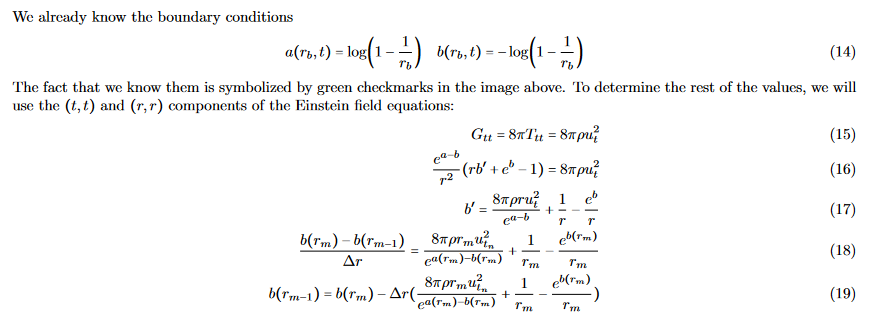

In [11]:
def obtain_time_derivatives():
    ## Calculate the time derivative of a(r,t):
    for point in grid_points:
      point.a_t = (point.a - point.a_previous)/delta_t
      point.a_previous = point.a

    ## We do not need to calculate the time derivative of b(r,t) at the grid points

In [12]:
def calculate_weighted_avg_for_dust_particles():
    ## For each dust particle, find nearby grid points in order to take their weighted average
    maximum_r_interp = 0.1
    for particle in dust_cloud:
      nearby_grid_points = get_points_in_radius(particle.r, particle.theta, particle.phi, grid_points, maximum_r_interp)
      total_dist = 1e-9
      weighted_a_t = 0
      weighted_a = 0
      weighted_b = 0
      weighted_a_r = 0
      weighted_b_r = 0

      for grid_point in nearby_grid_points:
        dist = norm(*spherical_to_cartesian(grid_point.r, grid_point.theta, grid_point.phi))
        total_dist += dist
        weighted_a_t += grid_point.a_t * dist
        weighted_a += grid_point.a * dist
        weighted_b += grid_point.b * dist
        weighted_a_r += grid_point.a_r * dist
        weighted_b_r += grid_point.b_r * dist

      particle.a_t = weighted_a_t/total_dist
      particle.a = weighted_a/total_dist
      particle.b = weighted_b/total_dist
      particle.a_r = weighted_a_r/total_dist
      particle.b_r = weighted_b_r/total_dist

      ## Non-interpolated
      particle.b_t = particle.rho * particle.r * particle.u_t * particle.u_r

In [13]:
## Now, at this stage, the necessary values for calculating the geodesic equations are known at the locations of the dust particles

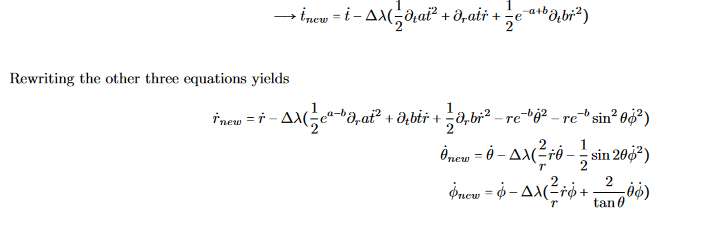

In [14]:
## We approximate the changes in each variable with respect to lambda, then scale them all in order to obtain a correct value for \dot{t} <- wrt \lambda
## then assign those quantities to the dust particles
## and run the simulation forward

delta_lambda = 1e4

def update_geodesic_for_dust_particles():
    for p in dust_cloud:
      delta_tdot = -delta_lambda * (0.5 * p.a_t * p.t_dot**2 + \
                                    p.a_r * p.t_dot * p.r_dot + \
                                    0.5 * np.exp(-p.a + p.b) * p.b_t * p.r_dot**2)

      delta_rdot = -delta_lambda * (0.5 * np.exp(p.a - p.b) * p.a_r * p.t_dot**2 + \
                                   p.b_t * p.t_dot * p.r_dot + \
                                   0.5 * p.b_r * p.r_dot**2 - \
                                   p.r * np.exp(-p.b) * p.theta_dot ** 2 - \
                                   p.r * np.exp(-p.b) * np.sin(p.theta)**2 * p.phi_dot**2)

      delta_thetadot = -delta_lambda * (2/p.r * p.r_dot * p.theta_dot - \
                                       0.5 * np.sin(2*p.theta) * p.phi_dot**2)

      delta_phidot = -delta_lambda * (2/p.r * p.r_dot * p.theta_dot + \
                                      2/np.tan(p.theta) * p.theta_dot * p.phi_dot)

      p.t_dot = p.t_dot + delta_tdot
      p.r_dot = p.r_dot + delta_rdot
      p.theta_dot = p.theta_dot + delta_thetadot
      p.phi_dot = p.phi_dot + delta_phidot



In [15]:
def move_dust_particles():
    for p in dust_cloud:
      scaling = delta_t / p.t_dot
      change_r =  p.r_dot * scaling
      change_theta = p.theta_dot * scaling
      change_phi = p.phi_dot * scaling


      p.change_r = change_r
      p.change_theta = change_theta
      p.change_phi = change_phi

      p.u_t = delta_t
      p.u_r = change_r
      p.u_theta = change_theta
      p.u_phi = change_phi

      '''p.u_r = -change_r
      p.u_theta = -change_theta
      p.u_phi = -change_phi'''

In [ ]:
N_STEPS = 100
np.random.seed(10)

# random_init_dust(800)
random_init_dust(300)

for simulation_step in range(N_STEPS):
    print(f"Starting iteration {simulation_step}.")

    # First, save an image displaying the dust particles' locations:
    save_dust_cloud_image(f"images/pos_{simulation_step}.png", simulation_step)

    loop_approximate_stress_energy()

    grid_boundary_r = -1

    # demarcate_grid_boundary()

    clear_grid_a_b()

    get_all_grid_a_b()
    obtain_time_derivatives()
    calculate_weighted_avg_for_dust_particles()
    update_geodesic_for_dust_particles()

    move_dust_particles()

    save_spatial_velocity_vector_image(f"images/vel_{simulation_step}.png", simulation_step)
    for p in dust_cloud:
      p.r += p.u_r
      p.theta += p.u_theta
      p.phi += p.u_phi
    print(f"Finished iteration {simulation_step}.")



Starting iteration 0.
Finished iteration 0.
Starting iteration 1.
